In [1]:
# import everything
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn import preprocessing 
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA


In [2]:
from sklearn import datasets

df = pd.read_csv('bank.csv')
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


In [3]:
df = df.drop(columns=['contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous' , 'poutcome'])
df.tail()

,age,job,marital,education,default,balance,housing,loan,y
4516,33,services,married,secondary,no,-333,yes,no,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,no
4518,57,technician,married,secondary,no,295,no,no,no
4519,28,blue-collar,married,secondary,no,1137,no,no,no
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,no


In [4]:
dict = {
    'no': 0,
    'yes': 1
}

dict_edu = {
    'primary': 1,
    'secondary':2,
    'tertiary':3
}

dict_married = {
    'single': 1,
    'married': 2,
    'divorced': 3
}

dict_job = {
    'admin.': 1,
    'unemployed': 0,
    'management': 1,
    'housemaid': 1,
    'entrepreneur':1,
    "student": 0,
    "blue-collar": 1,
    "self-employed": 1,
    "retired": 0,
    "technician":1,
    "services":1
}


df['y'] = df['y'].map(dict)
df['default'] = df['default'].map(dict)
df['housing'] = df['housing'].map(dict)
df['loan'] = df['loan'].map(dict)

df['marital'] = df['marital'].map(dict_married)

df['education'] = df['education'].map(dict_edu)

df['job'] = df['job'].map(dict_job)

#drop NaN columns
df = df.dropna()

train_data=[df]
for dataset in train_data:
    dataset.loc[ dataset['age'] <= 22,'age'] = 0,
    dataset.loc[(dataset['age'] >  22) & (dataset['age'] <= 30),'age'] = 1,
    dataset.loc[(dataset['age'] > 30) & (dataset['age'] <= 40),'age'] = 2,
    dataset.loc[(dataset['age'] > 40 ) & (dataset['age'] <= 50),'age'] = 3,
    dataset.loc[(dataset['age'] > 50 ) & (dataset['age'] <= 60),'age'] = 4,
    dataset.loc[(dataset['age'] > 60 ) & (dataset['age'] <= 70),'age'] = 5,
    dataset.loc[ dataset['age'] > 70,'age'] = 6

df.head()

,age,job,marital,education,default,balance,housing,loan,y
0,1,0.0,2,1.0,0,1787,0,0,0
1,2,1.0,2,2.0,0,4789,1,1,0
2,2,1.0,1,3.0,0,1350,1,0,0
3,1,1.0,2,3.0,0,1476,1,1,0
4,4,1.0,2,2.0,0,0,1,0,0


In [5]:
#Need to sort the values according to independent variable in order to calculate accuracy
df.sort_values(by=['y'], inplace=True)
df = df.reset_index(drop=True)
df.tail()

,age,job,marital,education,default,balance,housing,loan,y
4306,6,0.0,2,3.0,0,14220,1,0,1
4307,2,1.0,1,3.0,0,12569,0,0,1
4308,3,1.0,3,3.0,0,755,0,0,1
4309,2,1.0,2,3.0,0,5355,0,0,1
4310,2,1.0,2,3.0,0,1265,1,0,1


In [6]:
def generate_dendogram(Z, max_d=0, P=150):
    plt.figure(figsize=(25, 10))
    plt.title('Dendogram')
    plt.xlabel('Outcome')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=P,                  
        leaf_rotation=90.,       
        leaf_font_size=8.,     
    )
    plt.axhline(y=max_d, c='k')
    plt.show()

[[ 1.000e+00  0.000e+00  2.000e+00  1.000e+00  0.000e+00  1.787e+03
   0.000e+00  0.000e+00]
 [ 4.000e+00  1.000e+00  2.000e+00  2.000e+00  0.000e+00  9.600e+01
   0.000e+00  0.000e+00]
 [ 2.000e+00  1.000e+00  2.000e+00  3.000e+00  0.000e+00 -2.760e+02
   0.000e+00  1.000e+00]
 [ 4.000e+00  0.000e+00  2.000e+00  2.000e+00  0.000e+00  4.130e+02
   0.000e+00  0.000e+00]
 [ 2.000e+00  1.000e+00  2.000e+00  1.000e+00  0.000e+00  6.550e+02
   1.000e+00  0.000e+00]]


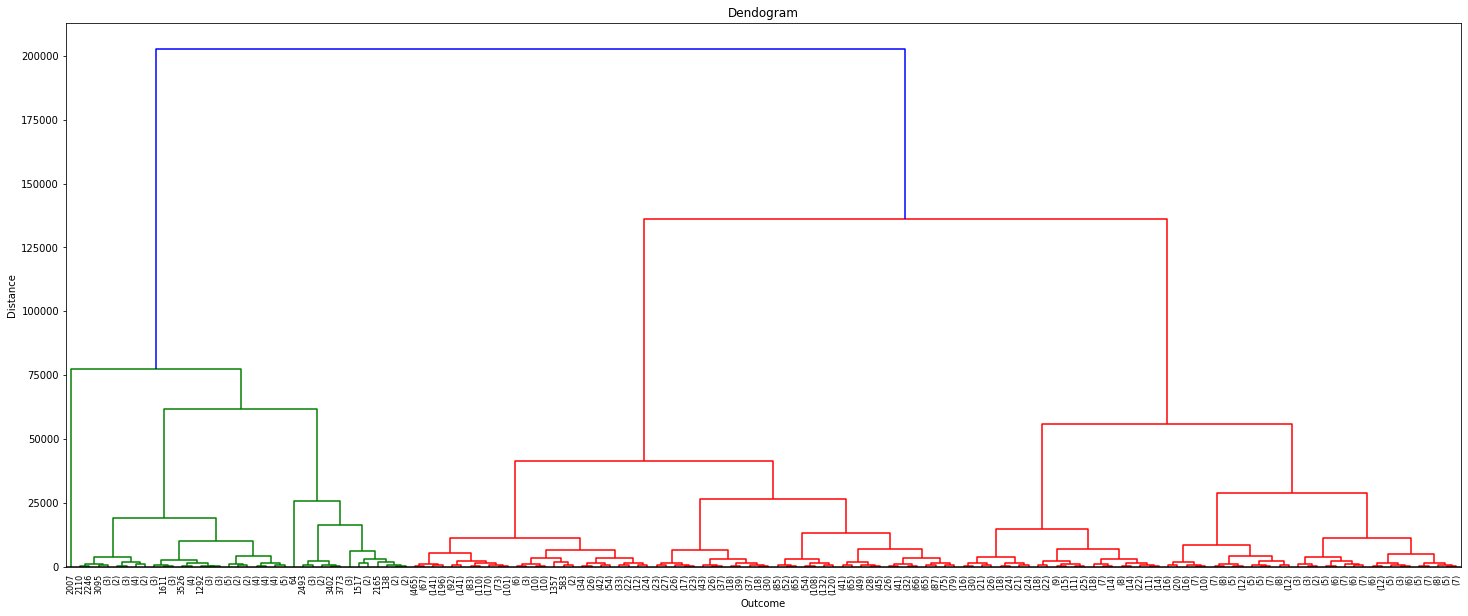

In [7]:
import time

x = df.loc[:, df.columns != 'y']
x = x.to_numpy()
print(x[0:5])

Z = linkage(x, 'ward')

generate_dendogram(Z)


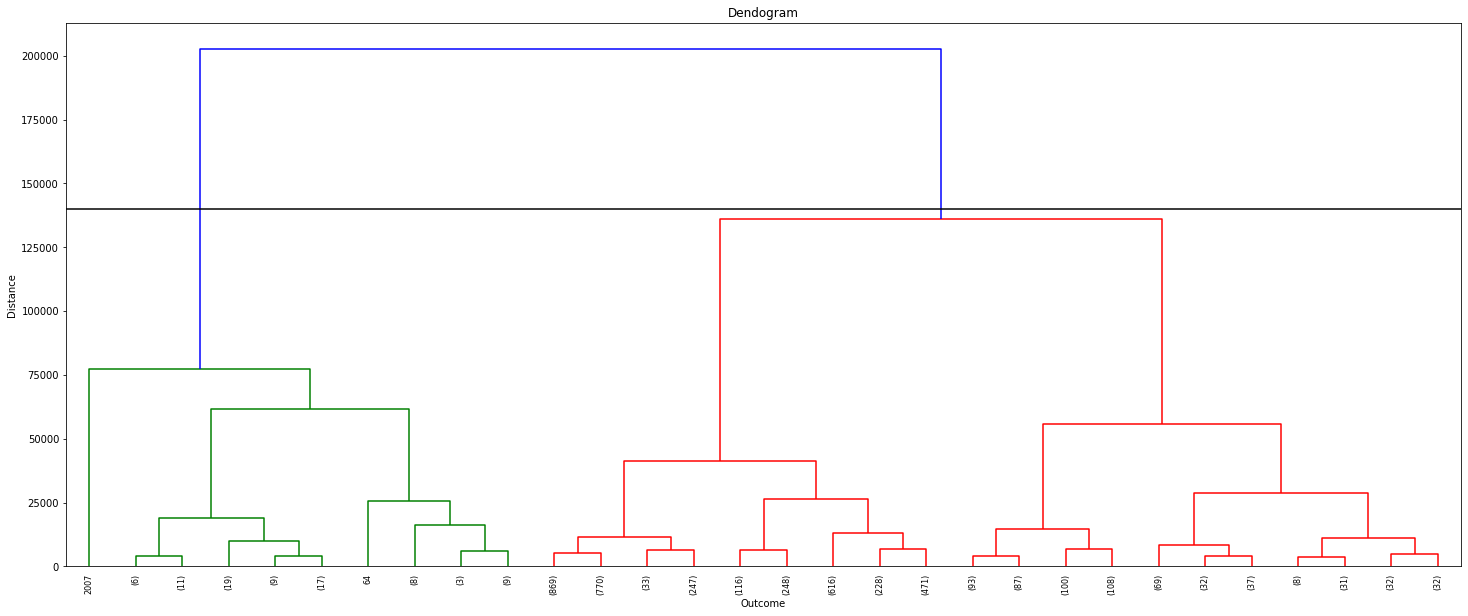

In [8]:
generate_dendogram(Z, max_d = 140000, P=30)

## Calculate the accuracy before PCA

In [9]:
#have a df with 1 column representing the actual category, and another column representing the predicted category

def generate_accuracy_table(y_pred):
    accuracy_table = pd.DataFrame(df['y'].to_numpy(), columns=['actual'])
    import copy
    y_pred2 = copy.deepcopy(y_pred)
    accuracy_table['predicted'] = y_pred2
    accuracy_table.head()
    return accuracy_table


In [10]:
#note that you do not know whether the 0 and 1 category for y_kmeans is equivalent to how we interpret 0 and 1. 
#We have have interpreted 0 as 'no' but the algorithim might interpret 0 as 'yes'

#thus, need to double check that algorithm and us are on the same page as to the interpretation of '0'
#let's just use the 1st 100 rows

def preview_distinct_values(accuracy_table):
    col_actual_sample = accuracy_table.iloc[0:100, 0]
    count_distinct_actual = col_actual_sample.value_counts()
    print("---actual---")
    print(count_distinct_actual)

    col_predicted_sample = accuracy_table.iloc[0:100, 1]
    count_distinct_predicted = col_predicted_sample.value_counts()
    print("---predicted---")
    print(count_distinct_predicted)

In [11]:
#calculate the accuracy for each category, with reference to the accuracy table

def calculate_accuracy_for_2_categories(accuracy_table):
    row_index = df['y'].idxmax(axis=1)
    predicted_cat0 = accuracy_table.loc[0 : row_index, 'predicted']
    predicted_cat1 = accuracy_table.loc[row_index : , 'predicted']
    
    from statistics import mean 
    total_accuracy = []
    
    for cat in [predicted_cat0, predicted_cat1]:
        count_distinct_predicted_cat = cat.value_counts()
        print(count_distinct_predicted_cat)
            #get the maximum occurence
        cat_max = count_distinct_predicted_cat.max()
        cat_accuracy = cat_max / count_distinct_predicted_cat.sum()
        print("category accuracy", cat_accuracy)
        total_accuracy.append(cat_accuracy)
        print()
    print('total accuracy:', mean(total_accuracy))

In [12]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="ward", n_clusters=2)

#Calculate time
start = time.time()
y_pred = clustering.fit_predict(x)
end= time.time()
speed = end - start
print("time taken", speed)

accuracy_table = generate_accuracy_table(y_pred)
preview_distinct_values(accuracy_table)
print()
calculate_accuracy_for_2_categories(accuracy_table)

time taken 0.7677192687988281
---actual---
0    100
Name: actual, dtype: int64
---predicted---
0    96
1     4
Name: predicted, dtype: int64

0    3735
1      79
Name: predicted, dtype: int64
category accuracy 0.9792868379653906

0    493
1      5
Name: predicted, dtype: int64
category accuracy 0.9899598393574297

total accuracy: 0.9846233386614102


## Scatter plots before PCA

In [13]:
def plot_scatter(x, y_col, x_col_N, x_col_M, num_clusters):
    label_encoder = preprocessing.LabelEncoder() 
    y_col = label_encoder.fit_transform(y_col)
    print(np.unique(y_col))
    
    clustering = AgglomerativeClustering(linkage="ward", n_clusters=num_clusters)
    clustering.fit(x);
       
    
    X_plot = preprocessing.MinMaxScaler().fit_transform(x)  
    
    print(X_plot.shape)
    num_rows = X_plot.shape[0]

    colours = 'bgrcmykw'
    
    for i in range(num_rows):
        plt.text(X_plot[i, x_col_N], X_plot[i, x_col_M], str(clustering.labels_[i]),
                 color=colours[y_col[i]],
                 fontdict={'weight': 'bold', 'size': 9}
            )

    plt.show()

[0 1]
(4311, 8)


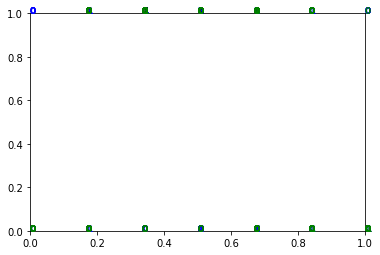

In [14]:
plot_scatter(x, 
            y_col = df['y'],
            x_col_N = 0,
            x_col_M = 1,
            num_clusters=2) #since there are only 2 clusters

[0 1]
(4311, 8)


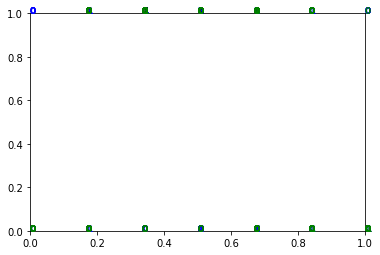

[0 1]
(4311, 8)


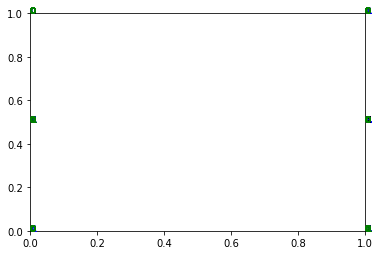

[0 1]
(4311, 8)


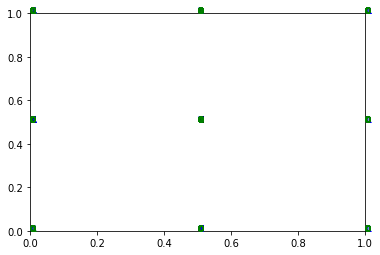

[0 1]
(4311, 8)


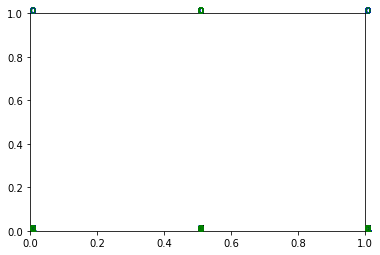

[0 1]
(4311, 8)


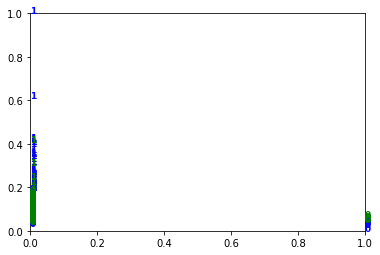

[0 1]
(4311, 8)


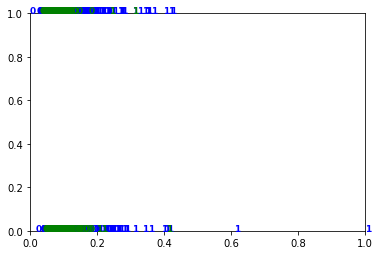

[0 1]
(4311, 8)


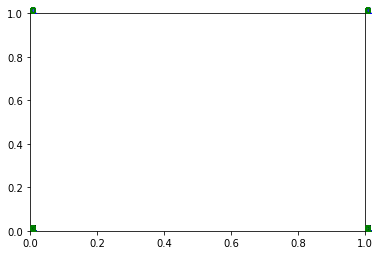

In [15]:
for i in range(1, len(df.columns) - 1):
    plot_scatter(x, 
            y_col = df['y'],
            x_col_N = i-1,
            x_col_M = i,
            num_clusters=2)
    
#only when i is 1, does the scatter plot make sense

In [16]:
df.corr()

,age,job,marital,education,default,balance,housing,loan,y
age,1.000000,-0.237660,0.383846,-0.184876,-0.014700,0.083115,-0.177020,0.002971,0.035950
job,-0.237660,1.000000,-0.027628,0.106736,-0.000351,-0.044722,0.181315,0.041051,-0.088157
marital,0.383846,-0.027628,1.000000,-0.125068,0.017544,-0.026157,0.025026,0.048237,-0.019296
education,-0.184876,0.106736,-0.125068,1.000000,-0.011787,0.055009,-0.073486,-0.024163,0.057245
default,-0.014700,-0.000351,0.017544,-0.011787,1.000000,-0.070011,0.003962,0.061224,-0.002435
balance,0.083115,-0.044722,-0.026157,0.055009,-0.070011,1.000000,-0.051041,-0.075818,0.016368
housing,-0.177020,0.181315,0.025026,-0.073486,0.003962,-0.051041,1.000000,0.013979,-0.105532
loan,0.002971,0.041051,0.048237,-0.024163,0.061224,-0.075818,0.013979,1.000000,-0.073333
y,0.035950,-0.088157,-0.019296,0.057245,-0.002435,0.016368,-0.105532,-0.073333,1.000000


In [17]:
def generate_newDf_with_PCA(num_cols, x):
    pca = PCA(n_components = num_cols)
    from sklearn.preprocessing import StandardScaler

    x = StandardScaler().fit_transform(x)
    principalComponents = pca.fit_transform(x)
    
    column_names = []
    for i in range(num_cols):
        name = 'pc ' + str(i)
        column_names.append(name)
    
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = column_names)
    principalDf.head()
    finalDf = pd.concat([principalDf, df[['y']]], axis = 1)
    finalDf.head(5)
    print(pca.explained_variance_ratio_)
    print(pca.explained_variance_ratio_.sum())
    return finalDf



In [18]:
finalDf = generate_newDf_with_PCA(4, x)
finalDf = finalDf.dropna()
final_x = finalDf.loc[:, finalDf.columns != 'y']
print(final_x)



[0.20138465 0.15586271 0.13344624 0.12199225]
0.6126858457498991
          pc 0      pc 1      pc 2      pc 3
0     1.325828  1.055645 -0.816110 -2.355560
1     1.209662  0.278829 -0.196454  0.120828
2    -0.492116 -0.304181 -1.710125  1.911574
3     2.627317  1.346726 -1.077820 -1.236611
4    -0.027645 -1.105560  1.035690 -1.210348
...        ...       ...       ...       ...
4306  3.246192  3.011499  1.219514  1.213438
4307 -0.930171  3.312258  0.355239  1.474710
4308  0.923794  0.330816 -0.100573  1.472600
4309 -0.347652  1.625084 -0.040876  1.246886
4310 -0.992051  0.037566  0.522707  0.504806

[4311 rows x 4 columns]


In [19]:
finalDf

,pc 0,pc 1,pc 2,pc 3,y
0,1.325828,1.055645,-0.816110,-2.355560,0
1,1.209662,0.278829,-0.196454,0.120828,0
2,-0.492116,-0.304181,-1.710125,1.911574,0
3,2.627317,1.346726,-1.077820,-1.236611,0
4,-0.027645,-1.105560,1.035690,-1.210348,0
...,...,...,...,...,...
4306,3.246192,3.011499,1.219514,1.213438,1
4307,-0.930171,3.312258,0.355239,1.474710,1
4308,0.923794,0.330816,-0.100573,1.472600,1
4309,-0.347652,1.625084,-0.040876,1.246886,1


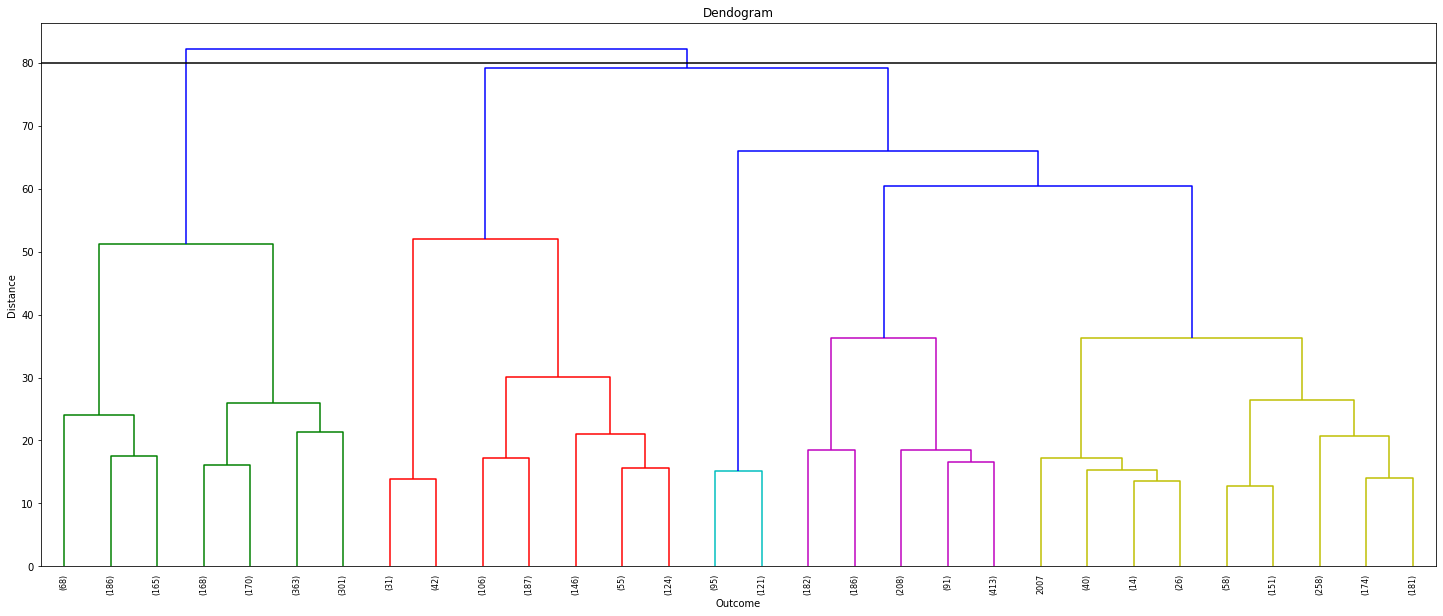

time taken 0.7243332862854004


In [20]:
Z = linkage(final_x, 'ward')


start = time.time()
generate_dendogram(Z, max_d = 80, P=30)
end= time.time()
speed = end - start
print("time taken", speed)



## Accuracy after PCA

In [21]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="ward", n_clusters=2)

start = time.time()
y_pred = clustering.fit_predict(final_x)
end= time.time()
speed = end - start
print("time taken", speed)

accuracy_table = generate_accuracy_table(y_pred)
preview_distinct_values(accuracy_table)
print()
calculate_accuracy_for_2_categories(accuracy_table)

time taken 0.8457334041595459
---actual---
0    100
Name: actual, dtype: int64
---predicted---
0    64
1    36
Name: predicted, dtype: int64

0    2577
1    1237
Name: predicted, dtype: int64
category accuracy 0.6756685894074462

0    313
1    185
Name: predicted, dtype: int64
category accuracy 0.6285140562248996

total accuracy: 0.6520913228161729


In [22]:
#Accuracy remains the same after PCA

## Scatter plot after PCA

[0 1]
(4311, 4)


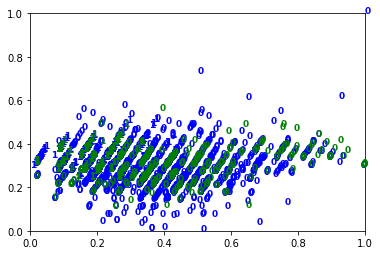

[0 1]
(4311, 4)


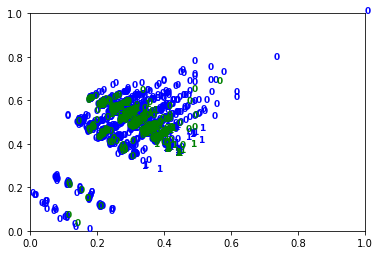

[0 1]
(4311, 4)


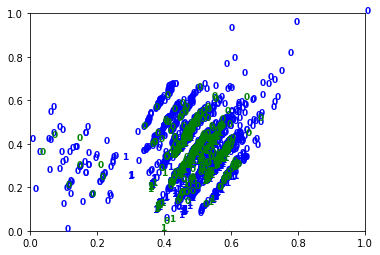

In [23]:
for i in range(1, len(finalDf.columns) - 1):
    plot_scatter(final_x, 
            y_col = finalDf['y'],
            x_col_N = i-1,
            x_col_M = i,
            num_clusters=2)